<a href="https://colab.research.google.com/github/s11khushboo/G1-Project/blob/main/image_classifier_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR-10 CNN Classifier
This notebook trains a Convolutional Neural Network on the CIFAR-10 dataset.  
It includes data preprocessing, augmentation, model training, evaluation, and prediction.

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras import layers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers.schedules import ExponentialDecay
from keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

## Load CIFAR-10 Data
We load the dataset

In [85]:
def load_cifar10_data(show_summary=True):
    """
    Load and optionally summarize the CIFAR-10 dataset.

    Parameters
    ----------
    show_summary : bool, optional
        If True, prints dataset shapes and statistics (default=True).

    Returns
    -------
    x_train,x_test,y_train,y_test : tuple
        Tuple containing the training and testing data.
    """

    # 1️⃣ Load CIFAR-10 dataset directly from Keras
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()

    # 2️⃣ Optional: show dataset info
    if show_summary:
        print("✅ CIFAR-10 Dataset Loaded Successfully")
        print(f"Training data shape : {x_train.shape}")
        print(f"Training labels shape: {y_train.shape}")
        print(f"Test data shape     : {x_test.shape}")
        print(f"Test labels shape   : {y_test.shape}")
        print(f"Pixel value range   : {x_train.min()}–{x_train.max()}")

    # 3️⃣ Return dataset
    return x_train, y_train, x_test, y_test
x_train, y_train, x_test, y_test=load_cifar10_data()

✅ CIFAR-10 Dataset Loaded Successfully
Training data shape : (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test data shape     : (10000, 32, 32, 3)
Test labels shape   : (10000, 1)
Pixel value range   : 0–255


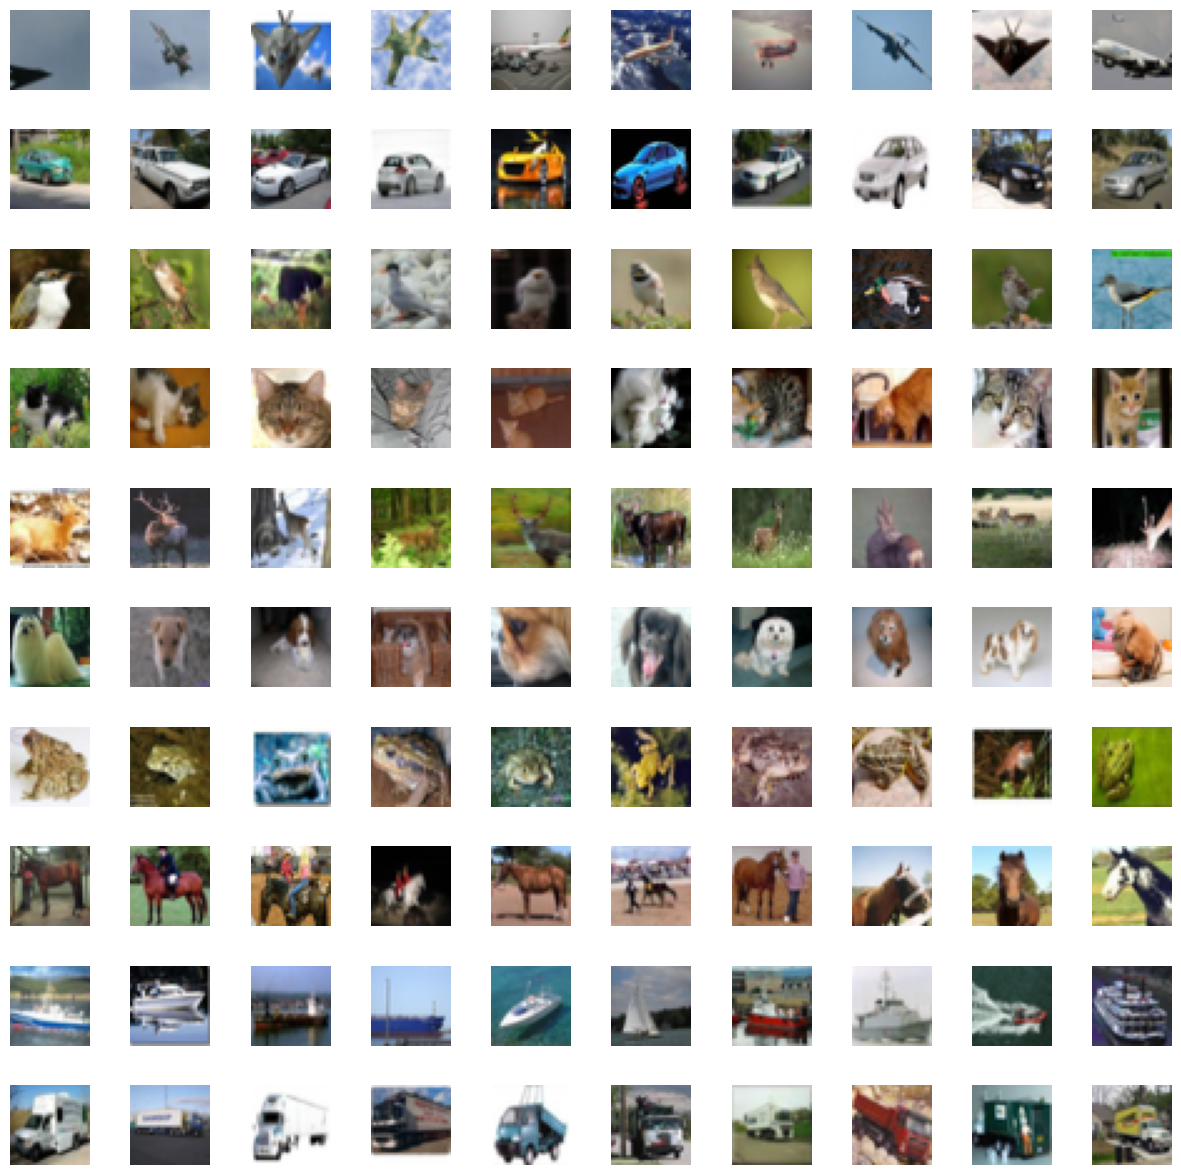

In [86]:
from matplotlib import image
from matplotlib import pyplot
fig, axes = plt.subplots(10, 10, figsize=(15, 15))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for class_idx in range(10):
    # Find all indices for the current class
    class_indices = np.where(y_train.flatten() == class_idx)[0]
    # Pick 10 random samples from this class
    random_indices = np.random.choice(class_indices, 10, replace=False)

    for i, img_idx in enumerate(random_indices):
        ax = axes[class_idx, i]
        ax.imshow(x_train[img_idx])
        ax.axis('off')


plt.show()



## Preprocessing Data
normalize pixel values between 0 and 1.  
Labels are one-hot encoded for categorical cross-entropy loss.

In [92]:
def prepare_data_generators(x_train, y_train, x_test, y_test, num_classes=10, batch_size=32):
  """
  Prepares ImageDataGenerators for training and testing a CNN model

  Returns
  -------
  train_generator :
        Data generator for training (with augmentation).
  test_generator :
        Data generator for testing (only normalization).
  """
  # One-hot encode labels
  y_train_onehot = to_categorical(y_train, num_classes=10)
  y_test_onehot = to_categorical(y_test, num_classes=10)

  datagen = image.ImageDataGenerator(
      rescale=1./255,             # Normalize
      rotation_range=15,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      zoom_range=0.1,
  )
  train_generator = datagen.flow(
      x_train, y_train_onehot,
      batch_size=32
  )

  test_datagen = image.ImageDataGenerator(rescale=1./255)
  test_generator = test_datagen.flow(x_test, y_test_onehot, batch_size=32,shuffle=False)
  return train_generator, test_generator

## CNN Architecture
- Input: 32x32 RGB images  
- Conv2D + ReLU + MaxPooling layers  
- Global Average Pooling  
- Dense layers + Softmax output (10 classes)

In [93]:
def build_cnn_model(input_shape=(32, 32, 3), num_classes=10):
    """
    Builds and returns a CNN model for CIFAR-10 classification.

    Parameters:
        input_shape (tuple): shape of input images (H, W, C)
        num_classes (int): number of output classes

    Returns:
        model (tf.keras.Model): compiled CNN model
    """
    model = Sequential([

      layers.Conv2D(32, (3,3),padding='same', activation='relu', input_shape=(32, 32, 3)),
      layers.BatchNormalization(),
      layers.MaxPooling2D(pool_size=(2, 2)),

      layers.Conv2D(64, (3,3),padding='same', activation='relu'),
      layers.BatchNormalization(),
      layers.MaxPooling2D((2,2)),

      layers.Conv2D(128, (3,3),padding='same', activation='relu'),
      layers.BatchNormalization(),
      layers.MaxPooling2D((2,2)),

      layers.Conv2D(512, (3,3),padding='same', activation='relu'),
      layers.BatchNormalization(),

      layers.GlobalAveragePooling2D(),
      layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
      layers.Dropout(0.5),

      layers.Dense(10, activation='softmax')
  ])
    model.compile(
        optimizer="adam",
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

## Training

- Optimizer: Adam
- Loss function: Categorical Crossentropy
- Number of epochs: 50  
- Early stopping is used to prevent overfitting.  
- Training uses data augmentation via `ImageDataGenerator`; batch size is defined in the generator.


In [94]:

from keras.backend import clear_session
clear_session()

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9
)
# build and trained the model
train_generator,test_generator=prepare_data_generators(x_train, y_train, x_test, y_test)
model=build_cnn_model()
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=50,
    callbacks=[early_stop, reduce_lr]
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 103s 63ms/step - accuracy: 0.4153 - loss: 1.9143 - val_accuracy: 0.5387 - val_loss: 1.5656 - learning_rate: 0.0010
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 97s 62ms/step - accuracy: 0.6187 - loss: 1.1850 - val_accuracy: 0.6048 - val_loss: 1.3204 - learning_rate: 0.0010
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 97s 62ms/step - accuracy: 0.6737 - loss: 1.0293 - val_accuracy: 0.7264 - val_loss: 0.8823 - learning_rate: 0.0010
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 99s 63ms/step - accuracy: 0.7007 - loss: 0.9490 - val_accuracy: 0.7344 - val_loss: 0.8559 - learning_rate: 0.0010
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 97s 62ms/step - accuracy: 0.7263 - loss: 0.8851 - val_accuracy: 0.6413 - val_loss: 1.1762 - learning_rate: 0.0010
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 98s 63ms/step - accuracy: 0.7405 - loss: 0.8453 - val_accuracy: 0.7076 - val_loss: 0.9443 - learning_rate: 0.0010
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 99s 63ms/step - accur

In [95]:
model.save("ic_cnn_model.keras")

In [96]:
model=tf.keras.models.load_model("ic_cnn_model.keras")

## Evaluation
We calculate accuracy, precision, recall, F1-score, and display a confusion matrix.


In [97]:
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc:.3f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8665 - loss: 0.4411
Test Accuracy: 0.863


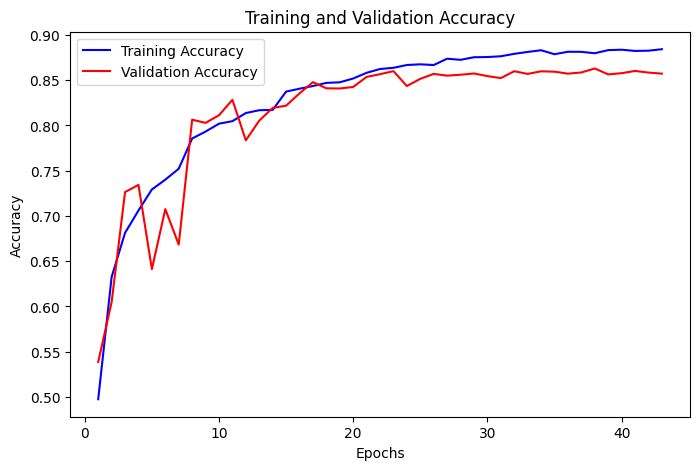

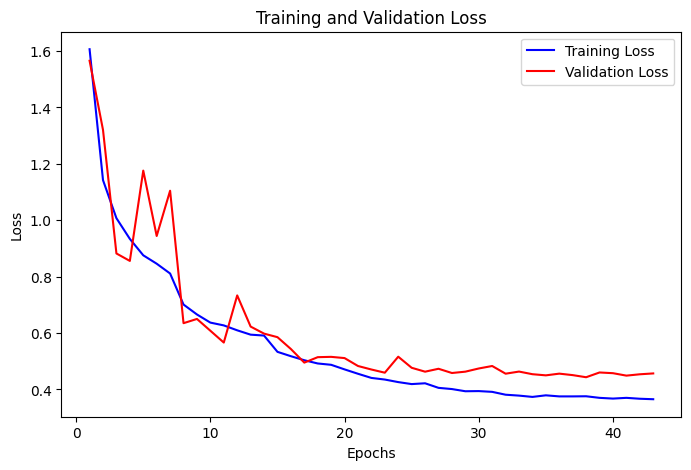

In [98]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

# Plot
plt.figure(figsize=(8,5))
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8,5))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()




In [99]:

def evaluate_cnn_model(model, test_generator):
    """
    Evaluate a trained CNN model using standard classification metrics.

    Computes and prints:
    - Accuracy
    - Precision (macro average)
    - Recall (macro average)
    - F1-score (macro average)
    - Confusion matrix
    Returns
    -------
    metrics_dict : dict
        Dictionary containing accuracy, precision, recall, and F1-score.
    """

    # 1️⃣ Get predictions from the model
    print("🔍 Generating predictions...")
    y_pred_probs = model.predict(test_generator)
    y_pred = np.argmax(y_pred_probs, axis=1)  # predicted class indices
    y_true = np.argmax(test_generator.y, axis=1)          # true labels from generator

    # 2️⃣ Compute metrics
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    # 3️⃣ Print results
    print("\n📊 Model Evaluation Metrics")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1-score : {f1:.4f}")
    print("\nDetailed Classification Report:\n")


    # 5️⃣ Return metrics
    metrics_dict = {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }

    return metrics_dict

In [100]:

metrics = evaluate_cnn_model(model, test_generator)
print(metrics)

🔍 Generating predictions...
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step

📊 Model Evaluation Metrics
Accuracy : 0.8630
Precision: 0.8626
Recall   : 0.8630
F1-score : 0.8615

Detailed Classification Report:

{'accuracy': 0.863, 'precision': 0.8625945519329218, 'recall': 0.8629999999999999, 'f1_score': 0.8614783619724399}


In [101]:
def preprocess_new_image(img_path, target_size=(32, 32)):
    """
    Preprocess a new image to match the training/test generator setup.

    Parameters
    ----------
    img_path : str
        Path to the new image
    target_size : tuple
        Resize image to match training images

    Returns
    -------
    img_array : numpy.ndarray
        Preprocessed image ready for model.predict(), shape (1, H, W, C)
    """
    # Load and resize
    img = image.load_img(img_path, target_size=target_size)

    # Convert to array
    img_array = image.img_to_array(img)

    # Rescale (same as your ImageDataGenerator rescale)
    img_array = img_array / 255.0

    # Expand dims to create batch size of 1
    img_array = np.expand_dims(img_array, axis=0)

    return img_array

## Prediction
Demonstrate how to predict new images with the trained CNN model.

In [104]:
img_array = preprocess_new_image("/content/cat2.png", target_size=(32,32))

# Predict probabilities
pred_probs = model.predict(img_array)

# Get predicted class
pred_class = np.argmax(pred_probs, axis=1)[0]

# Map to class label if you have class_names
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
max_class = class_names[np.argmax(pred_probs[0])]
max_prob = np.max(pred_probs[0]) * 100
print(f"Predicted: {max_class} ({max_prob:.2f}%)")
pred_label = class_names[pred_class]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Predicted: cat (95.69%)
